<a href="https://colab.research.google.com/github/claudiasahd/SARIMAX_LSTM_Dengue/blob/main/Redes_Neurais_Dengue_Modely_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import SGD

In [2]:
# Carregar os dados
file_path = '/content/Banco de dados_dengue_semana_OK.csv'
data = pd.read_csv(file_path, delimiter=';', decimal=',', skipinitialspace=True)


In [3]:
# Ajustando os valores de data para gerar o gráfico como no exemplo
data['data'] = pd.to_datetime(data[['ano', 'semana']].astype(str).agg('-'.join, axis=1) + '-1', format='%Y-%U-%w')
data_sorted = data.sort_values('data')

In [4]:
# Normalização dos dados
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features = data[['ano','semana','casos','umidmin', 'umidmed', 'tempmin', 'tempmed', 'tempmax']]
target = data['casos']
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))


In [5]:
# Preparar os dados para o modelo LSTM
time_steps = 10
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(features_scaled, target_scaled, time_steps)

In [6]:
# Divisão em treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compilar e treinar o modelo
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,104 (250.41 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,053 (125.21 KB)

In [9]:
# Fazer predições em todo o conjunto de dados, incluindo a parte do início
y_pred = model.predict(X)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [10]:
# Reverter a escala das previsões e valores reais
y_test_original = scaler_target.inverse_transform(y_test)
y_pred_original = scaler_target.inverse_transform(y_pred)



In [11]:
# Garantir que as previsões e os valores reais sejam 1D
y_test_original = y_test_original.flatten()
y_pred_original = y_pred_original.flatten()



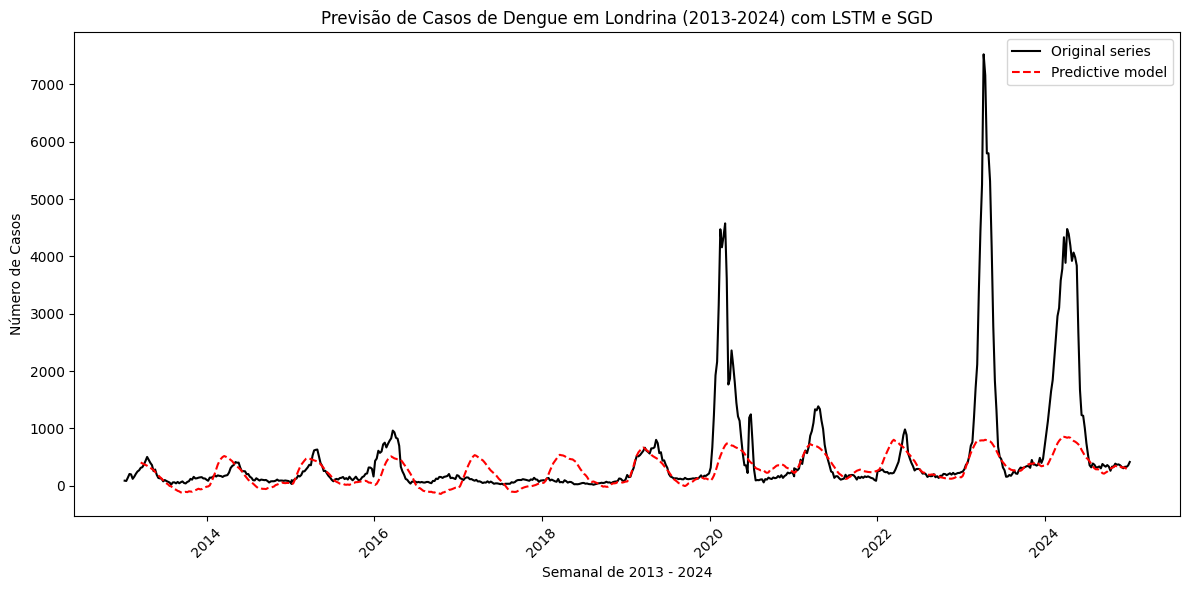

In [12]:
# Plotando o gráfico de série temporal
plt.figure(figsize=(12, 6))
plt.plot(data_sorted['data'], data_sorted['casos'], label='Original series', color='black')
plt.plot(data_sorted['data'].iloc[time_steps:], y_pred_original, label='Predictive model', linestyle='--', color='red')
plt.title('Previsão de Casos de Dengue em Londrina (2013-2024) com LSTM e SGD')
plt.xlabel('Semanal de 2013 - 2024')
plt.ylabel('Número de Casos')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
yhat = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Substitua os nomes conforme seu notebook
y_true = y_test.flatten()
y_pred = yhat.flatten()   # ou o nome correto da sua variável de predição

# Se os dados estiverem normalizados, aplique o inverso aqui:
# y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
# y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 0.23
MAE: 0.11
MAPE: 39.25%
